In [11]:
import pandas as pd
import numpy as np

train = pd.read_csv("UNSW-NB15/UNSW_NB15_testing-set.csv")
test = pd.read_csv("UNSW-NB15/UNSW_NB15_testing-set.csv")
train = train.drop(columns=['id'])
test = test.drop(columns=['id'])

In [9]:
train.shape

(175341, 44)

In [10]:
train.head()

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,1,1,0,0,0,1,1,0,Normal,0
1,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,1,2,0,0,0,1,6,0,Normal,0
2,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,1,3,0,0,0,2,6,0,Normal,0
3,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,1,3,1,1,0,2,1,0,Normal,0
4,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,1,40,0,0,0,2,39,0,Normal,0


In [12]:
train = train.dropna()
train = train.drop_duplicates()

In [21]:
train.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

In [3]:
np.array(train.dtypes == object)*1

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [ ]:
from preprocessing import encode_text_dummy

encode_text_dummy(train, "proto")
encode_text_dummy(test, "proto")
encode_text_dummy(train, "service")
encode_text_dummy(test, "service")
encode_text_dummy(train, "state")
encode_text_dummy(test, "state")

In [14]:
X_train = train.drop(columns=['attack_cat', 'label'])
y_train = train[['label']]
X_test = test.drop(columns=['attack_cat', 'label'])
y_test = test[['label']]

In [15]:
columns = X_train.columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [16]:
y_train.value_counts()

label
1        55850
0        51890
Name: count, dtype: int64

It's seem balance, so I don't need to use SMOTE to balance train set.

In [ ]:
X_train = pd.DataFrame(X_train, columns=columns)
X_test = pd.DataFrame(X_test, columns=columns)
encode_text_dummy(y_train, "label")
encode_text_dummy(y_test, "label")

# DEEP NEURAL MODEL

In [18]:
def evaluate_metric(y_pred, y_true):
    from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
    
    y_pred_ = np.argmax(y_pred, axis=1)
    y_true_ = np.argmax(y_true, axis=1)
    
    return {
        "confusion_matrix": confusion_matrix(y_true=y_true_, y_pred=y_pred_),
        "accuracy_score": accuracy_score(y_true=y_true_, y_pred=y_pred_),
        "precision_score": precision_score(y_true=y_true_, y_pred=y_pred_, average='micro'),
        "recall_score": recall_score(y_true=y_true_, y_pred=y_pred_, average='micro'),
        "f1_score": f1_score(y_true=y_true_, y_pred=y_pred_, average='micro')
    }
    

In [19]:
from art.estimators.classification import TensorFlowV2Classifier

import tensorflow as tf
n_classes = 2
layers = [
  tf.keras.layers.Dense(X_train.shape[0], activation='relu', input_shape=(X_train.shape[1],)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(n_classes, activation='softmax')
]
dnn = tf.keras.Sequential(layers)

loss_object = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

dnn_model = TensorFlowV2Classifier(
    model=dnn, 
    input_shape=X_train.shape, 
    nb_classes=2,
    optimizer=optimizer,
    loss_object=loss_object
    )

dnn_model.fit(X_train, y_train.values, nb_epochs=100, batch_size=100)

In [20]:
evaluate_metric(y_pred=dnn_model.predict(X_train), y_true=y_train.values)

{'confusion_matrix': array([[41637, 10253],
        [   45, 55805]]),
 'accuracy_score': 0.9044180434379061,
 'precision_score': 0.9044180434379061,
 'recall_score': 0.9044180434379061,
 'f1_score': 0.9044180434379061}

In [21]:
evaluate_metric(y_pred=dnn_model.predict(X_test), y_true=y_test.values)

{'confusion_matrix': array([[ 44667,  11333],
        [    48, 119293]]),
 'accuracy_score': 0.9350921917862907,
 'precision_score': 0.9350921917862907,
 'recall_score': 0.9350921917862907,
 'f1_score': 0.9350921917862905}

# Apply FSGM

In [25]:
from art.attacks.evasion.fast_gradient import FastGradientMethod
sample = X_test.sample(n=200)

fgm = FastGradientMethod(estimator=dnn_model, eps=0.2)

adv_sample = fgm.generate(x=sample.values)

In [31]:
sample.index

Index([120849,  35306,  47283, 115158, 175015, 153474, 137654,  83128,  35535,
        34886,
       ...
       143488, 161684, 109798, 146306,  23447,  50387,  54062, 122850,  50586,
        82424],
      dtype='int64', length=200)

In [38]:
evaluate_metric(y_pred=dnn_model.predict(sample), y_true=y_test.iloc[sample.index])

{'confusion_matrix': array([[ 52,  16],
        [  0, 132]]),
 'accuracy_score': 0.92,
 'precision_score': 0.92,
 'recall_score': 0.92,
 'f1_score': 0.92}

In [39]:
evaluate_metric(y_pred=dnn_model.predict(adv_sample), y_true=y_test.iloc[sample.index])

{'confusion_matrix': array([[ 50,  18],
        [132,   0]]),
 'accuracy_score': 0.25,
 'precision_score': 0.25,
 'recall_score': 0.25,
 'f1_score': 0.25}

# Apply XAI (SHAP) 

In [ ]:
import shap

background = X_train.sample(500)
deepExplainer = shap.DeepExplainer(model = dnn, data=background.values)
shap_val_of_sample = deepExplainer.shap_values(sample.values)
shap_val_of_adv_sample = deepExplainer.shap_values(adv_sample)

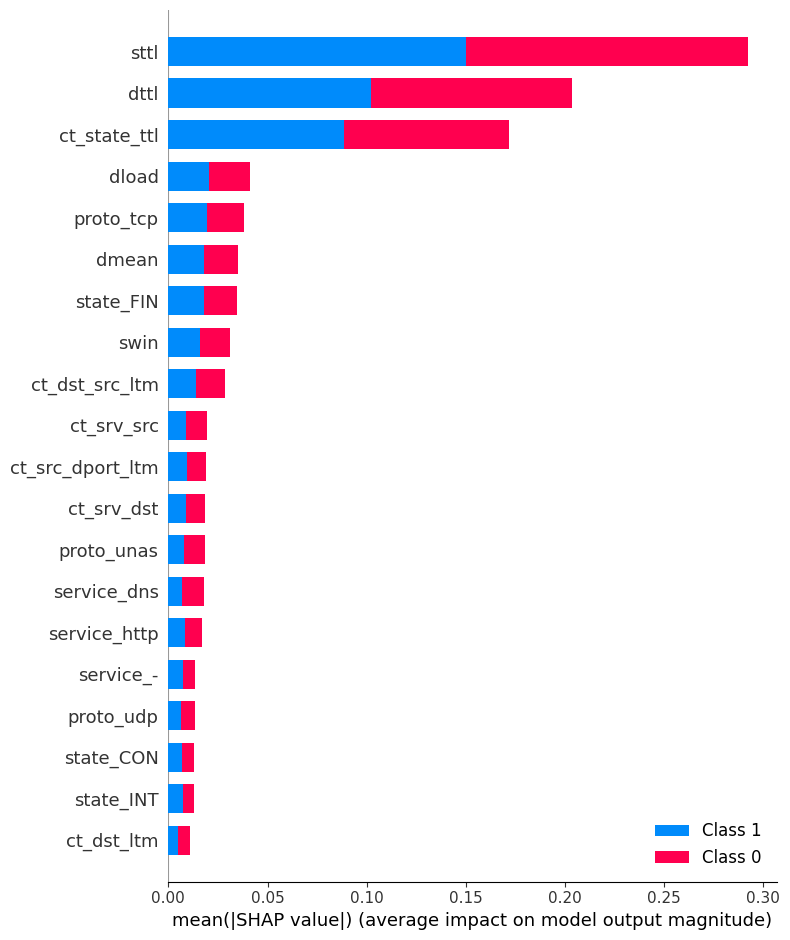

In [54]:
shap.summary_plot(shap_val_of_sample, columns)

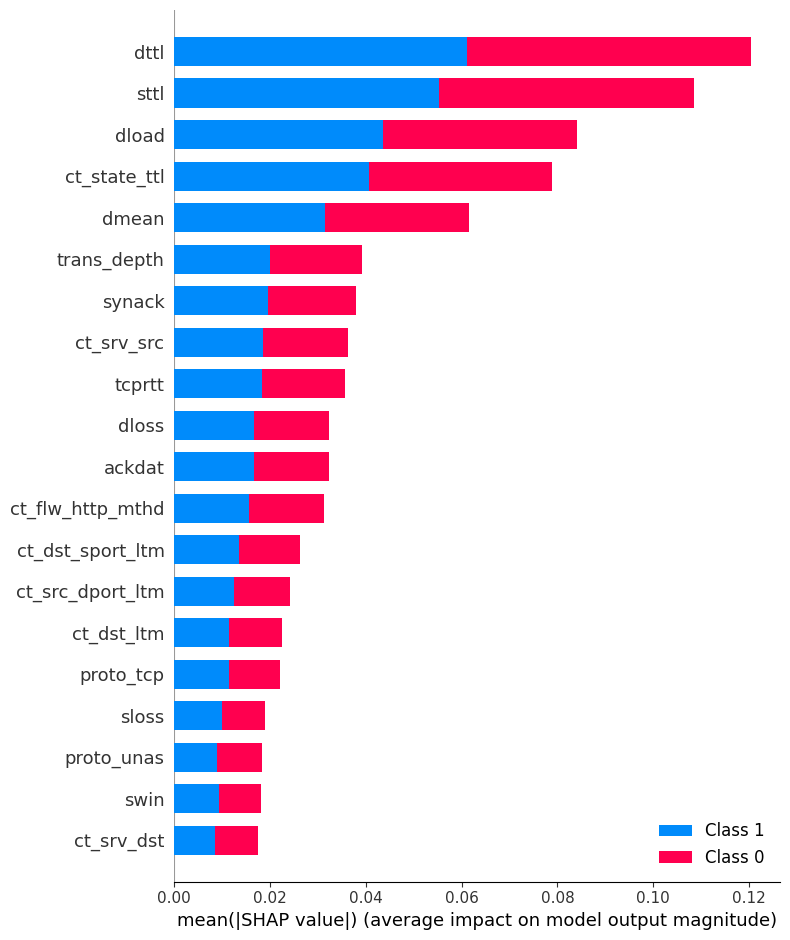

In [55]:
shap.summary_plot(shap_val_of_adv_sample, columns)